In [1]:
%load_ext autoreload
%autoreload 2
import sys
import scipy
import numpy as np
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
from clmm.dataops import _compute_lensing_angles_flatsky
from astropy.io import fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
sys.path.append('../modules/')
import clmm
import shear_multipole_modeling as model
import shear_multipole_from_data
import lensing_simulation_tools

from clmm import Cosmology
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.27 - 0.045, Omega_b=0.045, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
moo.set_concentration(4)
moo.set_mass(10**15.6)

In [2]:
import lenspack

In [3]:
from scipy import interpolate

In [4]:
z = 0.4
mass = 10**15
c=4
kappa_sph = model.surface_density_spherical(z, np.log10(mass), c, moo, convergence = True)

In [5]:
qxy = .8
ax = qxy**(-2)
a = ax
b = qxy*a
phi0 = np.pi/5

In [6]:
lim = 100
n = 1000
x = np.linspace(-lim, lim, n)
y = np.linspace(-lim, lim, n)
mapping_r = np.zeros([len(x), len(y)])
mapping_theta = np.zeros([len(x), len(y)])
mapping_r_sph = np.zeros([len(x), len(y)])
mapping_cosphi = np.zeros([len(x), len(y)])
mapping_sinphi = np.zeros([len(x), len(y)])

In [7]:
for i in range(len(x)):
    for j in range(len(y)):
        r_sph = np.sqrt(x[i]**2+y[j]**2)
        cosphi = x[j]/r_sph
        sinphi = y[i]/r_sph
        mapping_cosphi[i,j] =cosphi
        mapping_sinphi[i,j] =sinphi 
        cosphi_phi0 = cosphi*np.cos(phi0) + sinphi*np.sin(phi0)
        sinphi_phi0 = sinphi*np.cos(phi0) - cosphi*np.sin(phi0)
        r = r_sph*np.sqrt(cosphi_phi0**2/(a**2) + sinphi_phi0**2/(b**2))
        mapping_r[i,j] = r
        mapping_r_sph[i,j] = r_sph

In [8]:
kappa_mat = kappa_sph(mapping_r.flatten()).reshape(mapping_r.shape)/(a*b)
kappa_mat_sph = kappa_sph(mapping_r_sph.flatten()).reshape(mapping_r_sph.shape)

In [9]:
mapping_cos2phi = mapping_cosphi**2 - mapping_sinphi**2
mapping_sin2phi = 2 * mapping_cosphi * mapping_sinphi

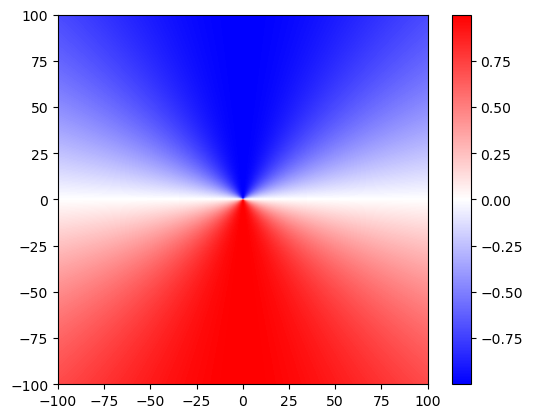

In [10]:
plt.imshow(mapping_sinphi,  extent=[-lim, lim, -lim, lim], cmap = 'bwr')
plt.colorbar()

In [11]:
gamma1, gamma2 = lenspack.image.inversion.ks93inv(kappa_mat, np.zeros(kappa_mat.shape))
kappaE, kappaB = lenspack.image.inversion.ks93(gamma1, gamma2)

In [12]:
Gamma = -(gamma1 + 1j* gamma2) * (mapping_cos2phi - 1j * mapping_sin2phi)

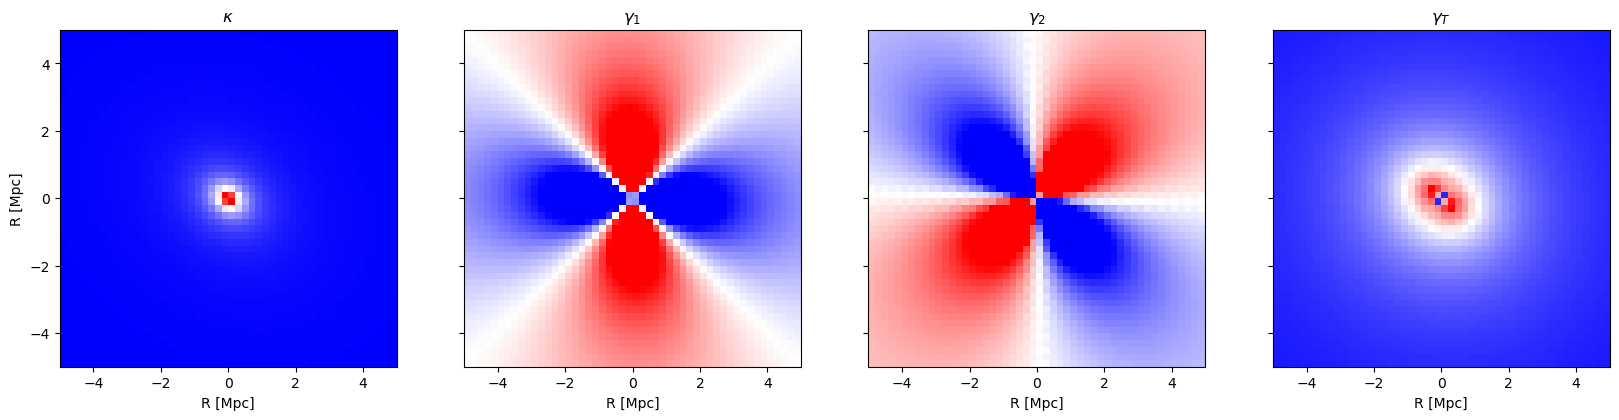

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey=True)
ax[0].imshow(kappa_mat, extent=[-lim, lim, -lim, lim], cmap='bwr', )
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)
ax[0].set_title(r'$\kappa$')
ax[1].imshow(gamma1, extent=[-lim, lim, -lim, lim], cmap='bwr', vmax = 0.02, vmin = -0.020,)
ax[1].set_title(r'$\gamma_1$')
ax[2].imshow(gamma2, extent=[-lim, lim, -lim, lim], cmap='bwr', vmax = 0.02, vmin = -0.020,)
ax[2].set_title(r'$\gamma_2$')
ax[3].imshow(Gamma.real, extent=[-lim, lim, -lim, lim], cmap='bwr', )
ax[3].set_title(r'$\gamma_T$')
ax[0].set_ylabel('R [Mpc]')
for i in range(4):
    ax[i].set_xlabel('R [Mpc]')

In [14]:
np.save('mock_shear_convergence_map', np.array([{'x':x, 'y':y, 
                                 'phi0': phi0,
                                 'qxy': qxy,
                                 'gamma1':gamma1, 
                                 'gammat':Gamma.real,
                                 'gammax':Gamma.imag,
                                 'gamma2':gamma2, 
                                 'kappa':kappa_mat}]),)